<a href="https://colab.research.google.com/github/zeerau/deeptech_ready/blob/main/1_Transformer_Architecture_Part_2_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

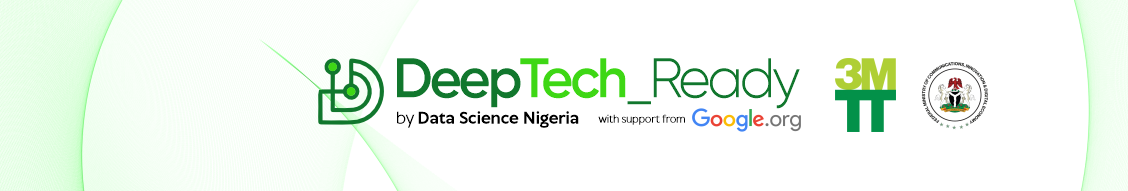

## Training Transformer Model for Machine Translation (Scratch)

## 0. Import Libraries and Setup

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch.nn import Transformer
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar

## 1. Data Preparation

In [ ]:
# === DATA PREPARATION ===
# Load the CSV file
df = pd.read_csv('english_french.csv')

# Extract English and French sentences
#source_sentences = df['English'].tolist()
#target_sentences = df['French'].tolist()


# Sample 1% of the data for illustration
df_sampled = df.sample(frac=0.01, random_state=42)

# Extract English and French sentences
source_sentences = df_sampled['English'].tolist()
target_sentences = df_sampled['French'].tolist()

# Check the sampled data size
print(f"Sampled data size: {len(df_sampled)}")

Sampled data size: 2298


## 2. Tokenization and Vocabulary

In [ ]:

# Tokenize function
def tokenize(sentence):
    return sentence.split()

# Build vocabulary
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2word = {0: "<pad>", 1: "<sos>", 2: "<eos>"}

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in tokenize(sentence):
                if word not in self.word2idx:
                    idx = len(self.word2idx)
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word

    def encode(self, sentence):
        return [self.word2idx[word] for word in tokenize(sentence)] + [2]  # Add <eos>

    def decode(self, indices):
        return " ".join([self.idx2word[idx] for idx in indices if idx > 2])

# Initialize vocabulary and build from the sentences
source_vocab = Vocabulary()
target_vocab = Vocabulary()
source_vocab.build_vocab(source_sentences)
target_vocab.build_vocab(target_sentences)

## 3. Dataset and DataLoader

In [ ]:
# Dataset class to handle source-target pairs
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = torch.tensor(self.src_vocab.encode(self.src_sentences[idx]), dtype=torch.long)
        tgt = torch.tensor(self.tgt_vocab.encode(self.tgt_sentences[idx]), dtype=torch.long)
        return src, tgt

# Create the dataset
dataset = TranslationDataset(source_sentences, target_sentences, source_vocab, target_vocab)

# Split dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Prepare DataLoader with padding and batch management
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=0, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=0, batch_first=True)
    return src_batch, tgt_batch

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

## 4. Model Definition

In [ ]:

# === MODEL DEFINITION ===
class TransformerSeq2Seq(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size):
        super(TransformerSeq2Seq, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 512, embed_size))
        self.transformer = Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(embed_size, tgt_vocab_size)

    def forward(self, src, tgt):
        src_embedded = self.src_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_embedded = self.tgt_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        transformer_output = self.transformer(src_embedded, tgt_embedded)
        output = self.fc(transformer_output)
        return output

embed_size = 64
num_heads = 4
num_layers = 2
ff_hidden_size = 128
src_vocab_size = len(source_vocab.word2idx)
tgt_vocab_size = len(target_vocab.word2idx)

model = TransformerSeq2Seq(src_vocab_size, tgt_vocab_size, embed_size, num_heads, num_layers, ff_hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## 5. Training and Validation

In [ ]:

# === TRAINING SETUP ===
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# === TRAINING AND VALIDATION ===
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def compute_accuracy(output, target):
    pred = output.argmax(dim=-1)
    correct = (pred == target).float()
    mask = (target != 0).float()  # Ignore padding
    accuracy = (correct * mask).sum() / mask.sum()
    return accuracy.item()

for epoch in range(10):
    model.train()
    train_loss, train_acc = 0, 0
    # Use tqdm to show progress in each epoch
    for src, tgt in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{10}', ncols=100, leave=False):
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += compute_accuracy(output, tgt_output)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc / len(train_loader))

    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for src, tgt in tqdm(val_loader, desc=f'Evaluating Epoch {epoch + 1}', ncols=100, leave=False):
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)
            val_loss += loss.item()
            val_acc += compute_accuracy(output, tgt_output)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc / len(val_loader))

    print(f"Epoch {epoch + 1} | Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1 | Train Loss: 6.8676, Val Loss: 6.3459 | Train Acc: 0.1493, Val Acc: 0.1484


Epoch 2 | Train Loss: 6.0627, Val Loss: 6.2887 | Train Acc: 0.1527, Val Acc: 0.1490


Epoch 3 | Train Loss: 5.7487, Val Loss: 6.0209 | Train Acc: 0.1831, Val Acc: 0.2149


Epoch 4 | Train Loss: 5.3025, Val Loss: 5.7818 | Train Acc: 0.2490, Val Acc: 0.2533


Epoch 5 | Train Loss: 4.8724, Val Loss: 5.6197 | Train Acc: 0.2901, Val Acc: 0.2712


Epoch 6 | Train Loss: 4.4751, Val Loss: 5.4948 | Train Acc: 0.3213, Val Acc: 0.2897


Epoch 7 | Train Loss: 4.1082, Val Loss: 5.4031 | Train Acc: 0.3551, Val Acc: 0.3081


Epoch 8 | Train Loss: 3.7715, Val Loss: 5.3282 | Train Acc: 0.3840, Val Acc: 0.3237


Epoch 9 | Train Loss: 3.4362, Val Loss: 5.2932 | Train Acc: 0.4105, Val Acc: 0.3354


Epoch 10 | Train Loss: 3.1437, Val Loss: 5.2925 | Train Acc: 0.4391, Val Acc: 0.3455


## Plot Validation Curves

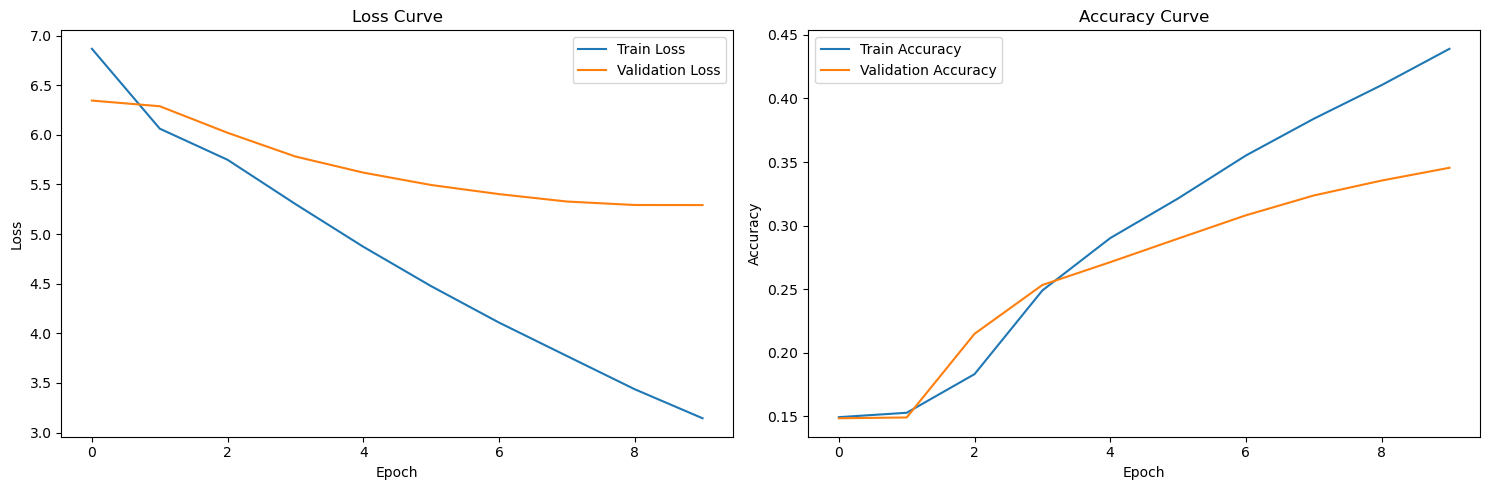

In [ ]:
# === PLOTTING RESULTS ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

## BLEU SCORE EVALUATION

In [ ]:
# === BLEU SCORE EVALUATION ===
def evaluate_bleu(model, dataset):
    model.eval()
    bleu_scores = []
    with torch.no_grad():
        for src_sentence, tgt_sentence in zip(source_sentences, target_sentences):
            src = torch.tensor([source_vocab.encode(src_sentence)], dtype=torch.long).to(device)
            tgt_input = torch.tensor([[1]], dtype=torch.long).to(device)  # <sos>

            for _ in range(10):  # Max translation length
                output = model(src, tgt_input)
                next_token = output[:, -1, :].argmax(dim=-1).item()
                tgt_input = torch.cat([tgt_input, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=1)
                if next_token == 2:  # <eos>
                    break

            generated = target_vocab.decode(tgt_input[0].cpu().numpy()).split()
            reference = [target_vocab.decode(target_vocab.encode(tgt_sentence)).split()]
            bleu_scores.append(sentence_bleu(reference, generated))

    return sum(bleu_scores) / len(bleu_scores)

# Evaluate BLEU score
bleu_score = evaluate_bleu(model, val_dataset)
print(f"BLEU Score: {bleu_score:.4f}")


C:\anaconda3\envs\pytorch_env\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\anaconda3\envs\pytorch_env\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\anaconda3\envs\pytorch_env\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunc

BLEU Score: 0.0000
